# Testing the correlation between the two metrics we are exploring

In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches
from pathlib import Path

In [2]:
import sys

sys.path.append("../src")

In [3]:
from core import SITE_NAMES, FREQ_GROUPS, DC_COLOR_MAPPINGS
from cli import get_file_paths

import bout_clustering as bt_clustering
import bout_plotting as bt_plt
import subsampling as ss
import data_handling as dh
import plotting
import pipeline

In [4]:
type_key = 'lf_'
site_key = "Carp"
cycle_lengths = [1800, 360]
percent_ons = [0.1667]
specific_dc_tag = "1800of1800"

In [5]:
fig_details = dict()
fig_details['site_name'] = SITE_NAMES[site_key]
fig_details['freq_group'] = type_key.split('_')[0].upper()
if type_key:
    fig_details['freq_group'] = fig_details['freq_group'] + ' '

In [6]:
pipeline_params = dict()
pipeline_params["read_csv"] = True
pipeline_params["save_activity_grid"] = True
pipeline_params["save_presence_grid"] = True
pipeline_params["save_dc_night_comparisons"] = True
pipeline_params["save_activity_dc_comparisons"] = True
pipeline_params["save_presence_dc_comparisons"] = True
pipeline_params["show_plots"] = False
pipeline_params["show_PST"] = True
pipeline_params

{'read_csv': True,
 'save_activity_grid': True,
 'save_presence_grid': True,
 'save_dc_night_comparisons': True,
 'save_activity_dc_comparisons': True,
 'save_presence_dc_comparisons': True,
 'show_plots': False,
 'show_PST': True}

In [7]:
data_params = dict()
data_params["site_name"] = SITE_NAMES[site_key]
data_params["site_tag"] = site_key
data_params["type_tag"] = type_key
data_params["freq_tags"] = FREQ_GROUPS[type_key]
data_params["cycle_lengths"] = cycle_lengths
data_params["percent_ons"] = percent_ons
dc_tags = ss.get_list_of_dc_tags(data_params["cycle_lengths"], data_params["percent_ons"])
data_params["dc_tags"] = dc_tags
data_params["cur_dc_tag"] = specific_dc_tag
data_params['resolution_in_min'] = '30'
data_params['recording_start'] = '02:00'
data_params['recording_end'] = '13:30'
data_params

{'site_name': 'Carp Pond',
 'site_tag': 'Carp',
 'type_tag': 'lf_',
 'freq_tags': [13000, 43000],
 'cycle_lengths': [1800, 360],
 'percent_ons': [0.1667],
 'dc_tags': ['1800of1800', '300of1800', '60of360'],
 'cur_dc_tag': '1800of1800',
 'resolution_in_min': '30',
 'recording_start': '02:00',
 'recording_end': '13:30'}

In [8]:
file_paths = get_file_paths(data_params)
file_paths

{'raw_SITE_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/raw/Carp',
 'SITE_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/2022_bd2_summary/Carp',
 'bd2_TYPE_SITE_YEAR': 'bd2__lf_Carp_2022',
 'duty_cycled_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/2022_bd2_summary/Carp/duty_cycled',
 'dc_dets_TYPE_SITE_summary': 'dc_dets_lf_Carp_summary',
 'dc_bouts_TYPE_SITE_summary': 'dc_bouts_lf_Carp_summary',
 'dc_inds_TYPE_SITE_summary': 'dc_inds_lf_Carp_summary',
 'simulated_schemes_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/2022_bd2_summary/Carp/duty_cycled/simulated_schemes',
 'figures_SITE_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../figures/Carp',
 'activity_det_comparisons_figname': 'activity_det_comparisons_per_dc_LF_Carp',
 'dc_det_comparisons_figname': 'dc_det_comparisons_per_night_LF_Carp',
 'activity_bout_comparisons_figname': 'activity_bout_comparisons_per_dc_LF_Carp',
 'dc_bou

In [9]:
activity_dets_arr = pipeline.run_for_dets(data_params, pipeline_params, file_paths)
activity_bouts_arr = pipeline.run_for_bouts(data_params, pipeline_params, file_paths)

### The 2 metrics are:
1) Percent of time occupied by bouts per interval
2) Number of calls detected per interval

### **Questions we wanted to answer:**
##### 1) How similar are the curves generated from each metric?
##### 2) Are there situations where similarity decreases as a result of the activity?

In [10]:
dc_tag = '1800of1800'
activity_bouts_df = dh.construct_activity_grid_for_bouts(activity_bouts_arr, dc_tag)
on = int(dc_tag.split('of')[0])
total = int(dc_tag.split('of')[1])
recover_ratio = total / on
adjusted_bouts_df = recover_ratio*activity_bouts_df


activity_dets_df = dh.construct_activity_grid_for_number_of_dets(activity_dets_arr, dc_tag)
on = int(dc_tag.split('of')[0])
total = int(dc_tag.split('of')[1])
recover_ratio = total / on
adjusted_dets_df = recover_ratio*activity_dets_df

mean_number_of_dets = adjusted_dets_df.mean(axis=0)
mean_time_by_bouts = adjusted_bouts_df.mean(axis=0)
max_number_of_dets = adjusted_dets_df.max(axis=0)
max_time_by_bouts = adjusted_bouts_df.max(axis=0)
median_number_of_dets = adjusted_dets_df.median(axis=0)
median_time_by_bouts = adjusted_bouts_df.median(axis=0)
spearman_coeffs = adjusted_dets_df.corrwith(adjusted_bouts_df, method='spearman', axis=0)
pearson_coeffs = adjusted_dets_df.corrwith(adjusted_bouts_df, method='pearson', axis=0)

#### **Decided to use pandas.DataFrame.corrwith() to compute correlation coefficients between dates for each metric**

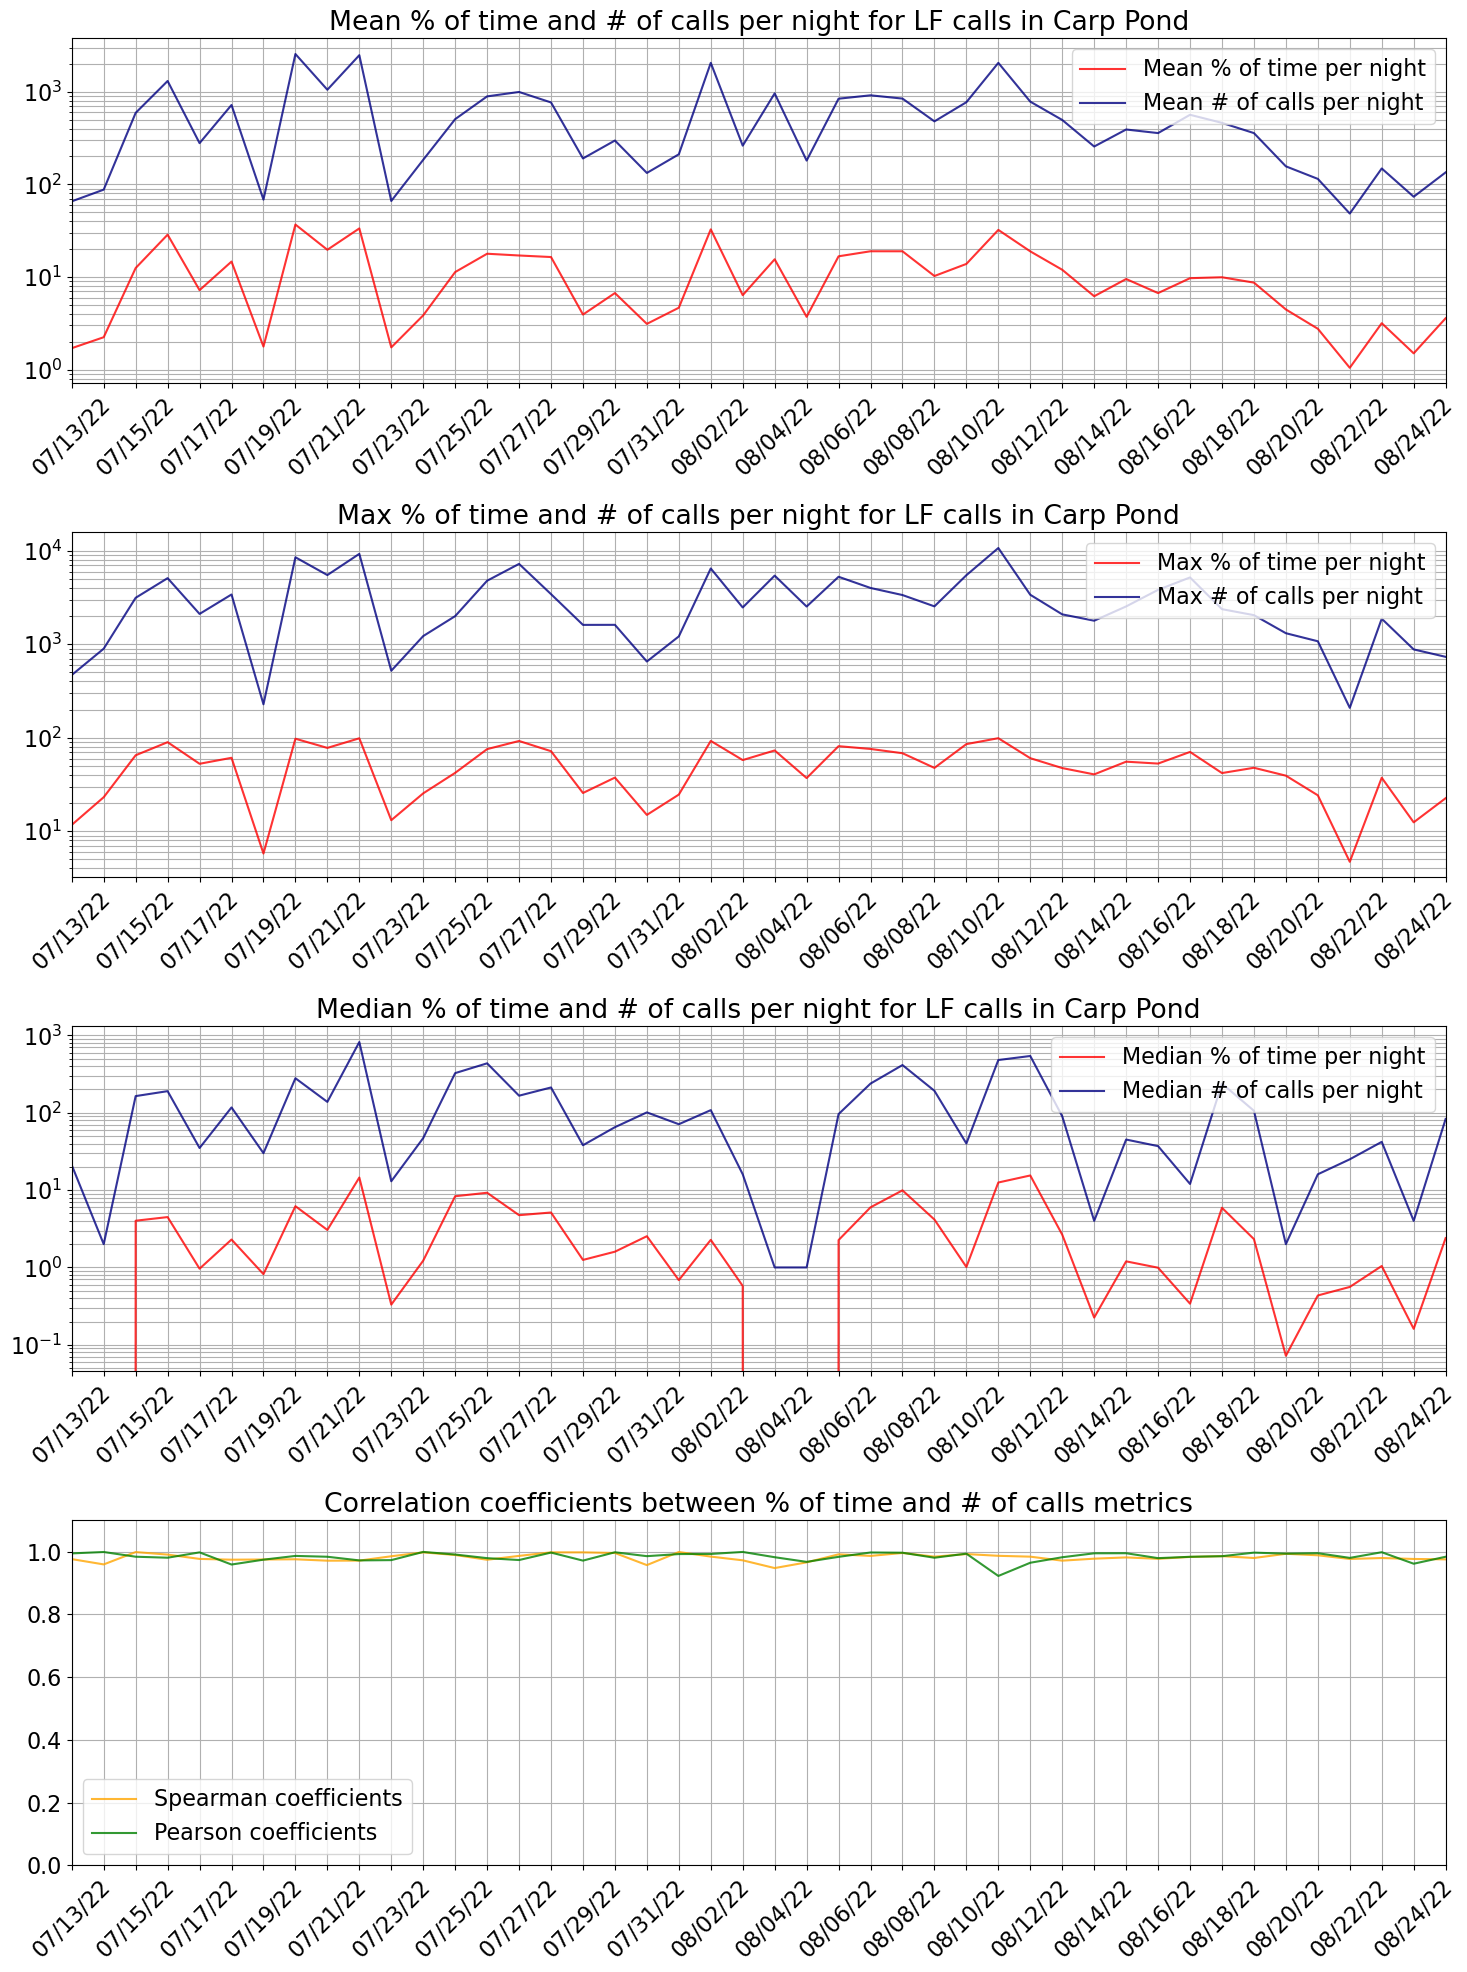

In [11]:
plt.figure(figsize=(15, 20))

plt.rcParams.update({'font.size':16})
plt.subplot(411)
plt.title(f'Mean % of time and # of calls per night for {fig_details["freq_group"]}calls in {fig_details["site_name"]}')
plt.plot(mean_time_by_bouts, color='red', alpha=0.8, label=f'Mean % of time per night')
plt.plot(mean_number_of_dets, color='navy', alpha=0.8, label='Mean # of calls per night')
plt.grid(which='both')
plot_xticks = [''] * len(adjusted_bouts_df.columns)
plot_xticks[::2] = adjusted_bouts_df.columns[::2]
plt.yscale('log')
plt.xticks(adjusted_bouts_df.columns, plot_xticks, rotation=45)
plt.xlim(0, len(adjusted_bouts_df.columns)-1)
plt.legend(loc='upper right')

plt.subplot(412)
plt.title(f'Max % of time and # of calls per night for {fig_details["freq_group"]}calls in {fig_details["site_name"]}')
plt.plot(max_time_by_bouts, color='red', alpha=0.8, label=f'Max % of time per night')
plt.plot(max_number_of_dets, color='navy', alpha=0.8, label='Max # of calls per night')
plt.grid(which='both')
plot_xticks = [''] * len(adjusted_bouts_df.columns)
plot_xticks[::2] = adjusted_bouts_df.columns[::2]
plt.yscale('log')
plt.xticks(adjusted_bouts_df.columns, plot_xticks, rotation=45)
plt.xlim(0, len(adjusted_bouts_df.columns)-1)
plt.legend(loc='upper right')

plt.subplot(413)
plt.title(f'Median % of time and # of calls per night for {fig_details["freq_group"]}calls in {fig_details["site_name"]}')
plt.plot(median_time_by_bouts, color='red', alpha=0.8, label=f'Median % of time per night')
plt.plot(median_number_of_dets, color='navy', alpha=0.8, label='Median # of calls per night')
plt.grid(which='both')
plot_xticks = [''] * len(adjusted_bouts_df.columns)
plot_xticks[::2] = adjusted_bouts_df.columns[::2]
plt.yscale('log')
plt.xticks(adjusted_bouts_df.columns, plot_xticks, rotation=45)
plt.xlim(0, len(adjusted_bouts_df.columns)-1)
plt.legend(loc='upper right')

plt.subplot(414)
plt.title(f'Correlation coefficients between % of time and # of calls metrics')
plt.plot(spearman_coeffs, color='orange', alpha=0.8, label='Spearman coefficients')
plt.plot(pearson_coeffs, color='green', alpha=0.8, label='Pearson coefficients')
plt.grid(which='both')
plot_xticks = [''] * len(adjusted_bouts_df.columns)
plot_xticks[::2] = adjusted_bouts_df.columns[::2]
plt.xticks(adjusted_bouts_df.columns, plot_xticks, rotation=45)
plt.xlim(0, len(adjusted_bouts_df.columns)-1)
plt.ylim(0, 1.1)
plt.legend()
plt.tight_layout()
plt.show()